Spring 2024: CSCI 6521 Programming Assignment #2

Student ID: 2623560

# 1. Load the Fashion-MNIST dataset from local drive. Load the data into the variables: X_train_full (60k), y_train_full (60k), X_valid (10k), and y_valid (10k) in the appropriate order. Split the training X_train_full (60k) data into X_train1 (59000) and [X_train2 (1000), y_train2(1000)].

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
# Importing required libraries
import os
import gzip
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2024-04-03 22:38:17.037397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 22:38:17.764250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
import gzip
import numpy as np

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return labels

def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        images = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    return images

def reshape_images(images, labels):
    return images.reshape(len(labels), 28, 28)

def load_and_prepare_data(data_dir):
    """Load and prepare MNIST dataset."""
    # Define file paths
    train_labels_path = os.path.join(data_dir, 'train-labels-idx1-ubyte.gz')
    train_images_path = os.path.join(data_dir, 'train-images-idx3-ubyte.gz')
    test_labels_path = os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz')
    test_images_path = os.path.join(data_dir, 't10k-images-idx3-ubyte.gz')

    # Load data
    y_train_full = load_mnist_labels(train_labels_path)
    X_train_full = load_mnist_images(train_images_path)
    y_valid = load_mnist_labels(test_labels_path)
    X_valid = load_mnist_images(test_images_path)

    # Reshape images
    X_train_full = reshape_images(X_train_full, y_train_full)
    X_valid = reshape_images(X_valid, y_valid)

    print(f'X_train_full shape = {X_train_full.shape}, X_valid shape: {X_valid.shape}')
    print(f'X_train_full reshaped to: {X_train_full.shape}, X_valid reshaped to:{X_valid.shape}')

    return X_train_full, y_train_full, X_valid, y_valid

data_dir = '/home/pthapa2/snap/padam/PA2/Fashion_MNIST_Data'
X_train_full, y_train_full, X_valid, y_valid = load_and_prepare_data(data_dir)

X_train_full shape = (60000, 28, 28), X_valid shape: (10000, 28, 28)
X_train_full reshaped to: (60000, 28, 28), X_valid reshaped to:(10000, 28, 28)


In [4]:
# Checking Info in the passed Dataset
def print_data_info():
  print('Training image:')
  print(f'min = {np.min(X_train_full)}, max = {np.max(X_train_full)}, datatype= {type(X_train_full[0][0][0])}')
  print('Training labels:')
  print(f'len(y_train_full) = {len(y_train_full)}, labels={np.unique(y_train_full)}')

print_data_info()

Training image:
min = 0, max = 255, datatype= <class 'numpy.uint8'>
Training labels:
len(y_train_full) = 60000, labels=[0 1 2 3 4 5 6 7 8 9]


In [5]:
# Normalizing the training and test images
X_train_full = X_train_full.astype(np.float32) / 255
X_valid = X_valid.astype(np.float32) / 255

print_data_info()

Training image:
min = 0.0, max = 1.0, datatype= <class 'numpy.float32'>
Training labels:
len(y_train_full) = 60000, labels=[0 1 2 3 4 5 6 7 8 9]


In [6]:
# Split the Dataset
X_train1, y_train1 = X_train_full[:-1000], y_train_full[:-1000]
X_train2, y_train2 = X_train_full[-1000:], y_train_full[-1000:]

In [7]:
# Display the resulting data shapes
print(f'X_train1: {X_train1.shape}, X_train2: {X_train2.shape}, y_train1:{y_train1.shape}, y_train2: {y_train2.shape}')

X_train1: (59000, 28, 28), X_train2: (1000, 28, 28), y_train1:(59000,), y_train2: (1000,)


# 2. Display some sample images dataset from the training dataset in a 6 × 8 grid.

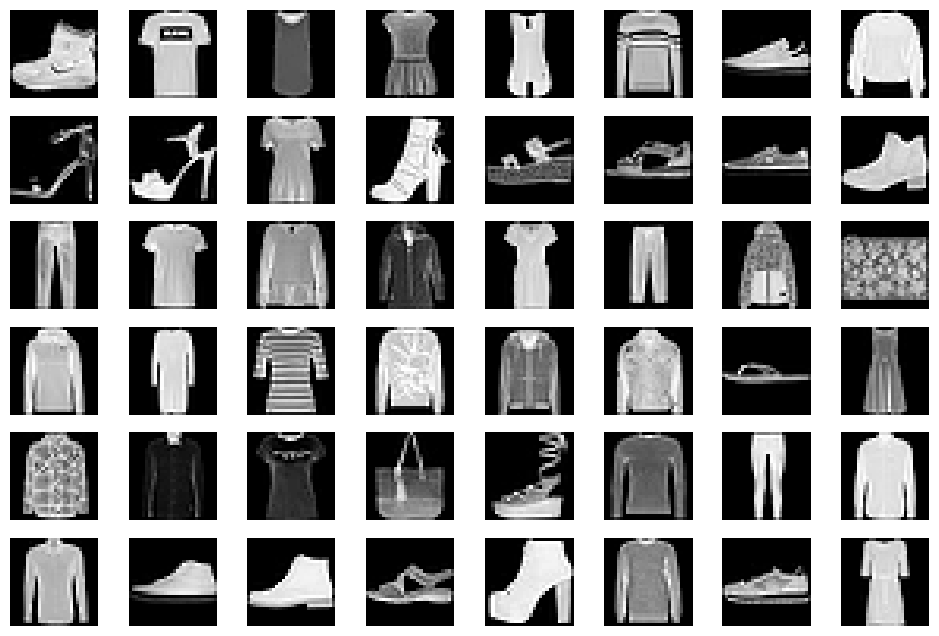

In [8]:
# Display sample images from X_train1
# 'axes.flat' iterator - allows us to iterate over the axes in a flat (1D) manner, eliminating the need for nested loops.
rows, cols = 6, 8
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
for ax, img in zip(axes.flat, X_train1[:rows * cols]):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

# 3. Model#1: Train a deep (using Convolutional Layers) denoising autoencoder using X_train1 and X_valid. Train it for at least 20 Epochs.

In [9]:
# Set random seed
seed = 2648567
tf.random.set_seed(seed)
np.random.seed(seed)

In [10]:
# define function for rounded accuracy
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
# Encoder
conv_enc = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Conv2D(filters=16, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2), keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', activation='selu'), keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

# Decoder
conv_dec = keras.models.Sequential([
    keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='VALID', activation='selu', input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='SAME', activation='selu'),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2,  padding='SAME', activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

# Autoencoder
conv_ae = keras.models.Sequential([conv_enc, conv_dec])
conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])
history = conv_ae.fit(X_train1, X_train1, epochs=50, validation_data=(X_valid, X_valid))

2024-04-03 22:38:27.180902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78923 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:88:00.0, compute capability: 8.0


Epoch 1/50


2024-04-03 22:38:30.143226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-04-03 22:38:31.857568: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb430043b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 22:38:31.857596: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-03 22:38:31.923200: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1844/1844 [==============================] - 10s 3ms/step - loss: 0.3047 - rounded_accuracy: 0.9173 - val_loss: 0.2830 - val_rounded_accuracy: 0.9377
Epoch 2/50
1844/1844 [==============================] - 6s 3ms/step - loss: 0.2821 - rounded_accuracy: 0.9363 - val_loss: 0.2794 - val_rounded_accuracy: 0.9389
Epoch 3/50
1844/1844 [==============================] - 6s 3ms/step - loss: 0.2784 - rounded_accuracy: 0.9399 - val_loss: 0.2750 - val_rounded_accuracy: 0.9448
Epoch 4/50
1844/1844 [==============================] - 6s 3ms/step - loss: 0.2762 - rounded_accuracy: 0.9420 - val_loss: 0.2742 - val_rounded_accuracy: 0.9459
Epoch 5/50
1844/1844 [==============================] - 6s 3ms/step - loss: 0.2747 - rounded_accuracy: 0.9435 - val_loss: 0.2714 - val_rounded_accuracy: 0.9489
Epoch 6/50
1844/1844 [==============================] - 6s 3ms/step - loss: 0.2735 - rounded_accuracy: 0.9448 - val_loss: 0.2704 - val_rounded_accuracy: 0.9500
Epoch 7/50
1844/1844 [============================

In [12]:
# Model architecture
conv_enc.summary(), conv_dec.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 28, 28, 1)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0

(None, None)

# 4. Extract the trained encoder part of the Model#1 trained in Step#3 and add two consequative dense layers using activation="selu" and activation="softmax” activation functions – the first Dense layer will have 30 nodes [Hints: add Flatten(), then add Dense(30), …].

In [13]:
# clone the encoder
clone_conv_enc = keras.models.clone_model(conv_enc)
# freeze training the encoder
clone_conv_enc.trainable = False

In [14]:
# build model#2
model_2 = keras.models.Sequential([
    clone_conv_enc,
    keras.layers.Flatten(),
    keras.layers.Dense(30, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])

In [15]:
# compile model#2
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.02), metrics=['accuracy'])

# 5. Train Model#2 using training dataset: [X_train2 (1000), y_train2(1000)] and validation dataset [X_valid, y_valid] for 20 Epoch. Return the training in “history” variable and plot the training graph using the “history” and DataFrame [Hints: Line#1: import pandas as pd, Line #2: pd.DataFrame(history.history).plot(), Line#3: plt.show()].

In [16]:
history_2 = model_2.fit(X_train2, y_train2, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
 1/32 [..............................] - ETA: 16s - loss: 2.4446 - accuracy: 0.1562

2024-04-03 22:43:28.740411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


32/32 [==============================] - 1s 20ms/step - loss: 2.2780 - accuracy: 0.1750 - val_loss: 2.2128 - val_accuracy: 0.2013
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 2.1781 - accuracy: 0.2670 - val_loss: 2.1190 - val_accuracy: 0.3152
Epoch 3/50
32/32 [==============================] - 0s 14ms/step - loss: 2.0897 - accuracy: 0.3580 - val_loss: 2.0367 - val_accuracy: 0.4488
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 2.0032 - accuracy: 0.4630 - val_loss: 1.9550 - val_accuracy: 0.4722
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 1.9180 - accuracy: 0.5310 - val_loss: 1.8725 - val_accuracy: 0.5206
Epoch 6/50
32/32 [==============================] - 0s 14ms/step - loss: 1.8358 - accuracy: 0.5590 - val_loss: 1.8026 - val_accuracy: 0.5280
Epoch 7/50
32/32 [==============================] - 0s 13ms/step - loss: 1.7648 - accuracy: 0.5620 - val_loss: 1.7204 - val_accuracy: 0.5804
Epoch 8/50
32/32 [======

In [17]:
# check model summary
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3, 3, 64)          23296     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 30)                17310     
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
Total params: 40,916
Trainable params: 17,620
Non-trainable params: 23,296
_________________________________________________________________


In [18]:
# get the validation accuracy of model#2
val_acc_2 = history_2.history['val_accuracy'][-1]
print(f'Model 2 validation accuracy: {val_acc_2}')

Model 2 validation accuracy: 0.7128000259399414


# 6. Rebuild Model#2 as Model#3 without including the trained weight of the encoder of Model#1 – and repeat the step as done in #5.

In [19]:
# build model#3
model_3 = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Conv2D(filters=16, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2), keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2), keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation='selu'), keras.layers.MaxPool2D(pool_size=2), keras.layers.Flatten(), keras.layers.Dense(30, activation='selu'), keras.layers.Dense(10, activation='softmax')
])

In [20]:
# compile model#3
model_3.compile(optimizer=keras.optimizers.SGD(learning_rate=0.02), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_3 = model_3.fit(X_train2, y_train2, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
32/32 [==============================] - 1s 21ms/step - loss: 1.8215 - accuracy: 0.4020 - val_loss: 1.5058 - val_accuracy: 0.5377
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 1.1182 - accuracy: 0.6190 - val_loss: 1.2498 - val_accuracy: 0.5309
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.9223 - accuracy: 0.6500 - val_loss: 1.0138 - val_accuracy: 0.6197
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.8587 - accuracy: 0.6740 - val_loss: 1.0564 - val_accuracy: 0.6549
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.7686 - accuracy: 0.7070 - val_loss: 1.0532 - val_accuracy: 0.6195
Epoch 6/50
32/32 [==============================] - 0s 14ms/step - loss: 0.7153 - accuracy: 0.7370 - val_loss: 0.9082 - val_accuracy: 0.6878
Epoch 7/50
32/32 [==============================] - 0s 15ms/step - loss: 0.6856 - accuracy: 0.7480 - val_loss: 0.8491 - val_accuracy: 0.6789
Epoch 8/50
32

In [22]:
# check model architecture
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 28, 28, 1)        0         
 oise)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)        

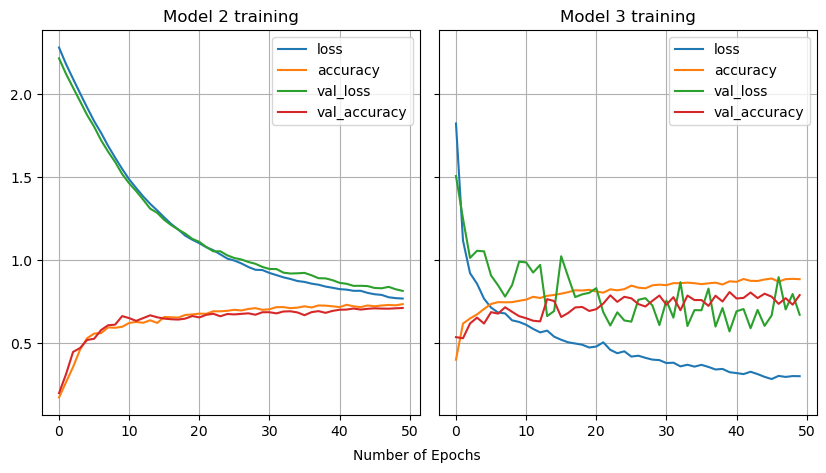

In [23]:
# plot training graph for model#2 and model#3
his3_df = pd.DataFrame(history_3.history)
his2_df = pd.DataFrame(history_2.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True, )
his2_df.plot(title= 'Model 2 training', ax=axes[0], grid='on')
his3_df.plot(title= 'Model 3 training', ax=axes[1], grid='on')
fig.text(0.5, 0.02, 'Number of Epochs', ha='center')
plt.subplots_adjust(wspace=0.05)

In [24]:
# model#3's validation accuracy
val_acc_3 = history_3.history['val_accuracy'][-1]
print(f'Model 3 validation accuracy: {val_acc_3}')

Model 3 validation accuracy: 0.7903000116348267


# 7. Comment on the (validation) accuracies of Model#2 versus Model#3:

The validation accuracies of Model 2 and Model 3 exhibit distinct behaviors during training. Initially, both models start with higher validation accuracy compared to their respective training accuracies. However, as training progresses, the training accuracy surpasses the validation accuracy in both cases. Model 3 demonstrates a more pronounced improvement in validation accuracy during the first two epochs compared to Model 2, suggesting a faster initial learning rate. After this initial phase, the rate of increase in validation accuracy appears to stabilize and become similar for both models. By the end of the 50th epoch, Model 3 achieves a higher validation accuracy of 0.7903, outperforming Model 2, which has a validation accuracy of 0.7128. Additionally, Model 3 shows a lower validation loss than Model 2, indicating better generalization and performance on the validation dataset.